# 02_DiD_estimates.ipynb

In [101]:
from differences import ATTgt
import figure_utilities
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import numpy as np
import os
import pandas as pd


# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/restricted.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/DiD/tables"

# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

/var/folders/lm/j45l41m16cs8sd5r9sh4gj6w0000gn/T/ipykernel_1842/2307055463.py:17: DtypeWarning: Columns (149,151) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(INPUT_DATA)


In [102]:
# Store a list of column names containing Zestimates.
years = [str(year) for year in range(2013, 2023)]
months = ["0" + str(month) for month in range(1, 10)] + [str(month) for month in range(10, 13)]
value_vars = ["2012-12"] + [str(year) + "-" + str(month) for year in years for month in months]

# Create dictionaries to map between string represetation and integer representation of each month.
month_to_int_dictionary = {key: value for value, key in enumerate(value_vars)}
int_to_month_dictionary = {key: value for key, value in enumerate(value_vars)}

In [103]:
# Drop rows for which we are missing any Zestimates.
has_all_zestimates_mask = df[value_vars].notna().all(axis=1) 
print(f"Limiting sample to {has_all_zestimates_mask.sum()} evictions for which we observe Zestimates at every month "
      "from 2012-12 to 2022-12.")
df = df.loc[has_all_zestimates_mask, :]

Limiting sample to 2948 evictions for which we observe Zestimates at every month from 2012-12 to 2022-12.


In [104]:
# Reshape from wide to long.
df = pd.melt(df,
             id_vars=['case_number', 'file_date', 'judgment_for_plaintiff'],
             value_vars=value_vars, var_name='month', value_name='zestimate')
df = df.sort_values(by=['case_number', 'month'])

# Get 'first treated' date for each observation.
df.loc[:, 'file_date'] = pd.to_datetime(df['file_date']).dt.strftime('%Y-%m')

# Convert months from string format to integer format.
df.loc[:, 'month'] = df['month'].replace(month_to_int_dictionary)
df.loc[:, 'file_date'] = df['file_date'].replace(month_to_int_dictionary)
never_treated_mask = (df['judgment_for_plaintiff'] == 0)
df.loc[never_treated_mask, 'file_date'] = 'control'

# Set index to entity and time.
df = df.set_index(['case_number', 'month'])

77
78
79


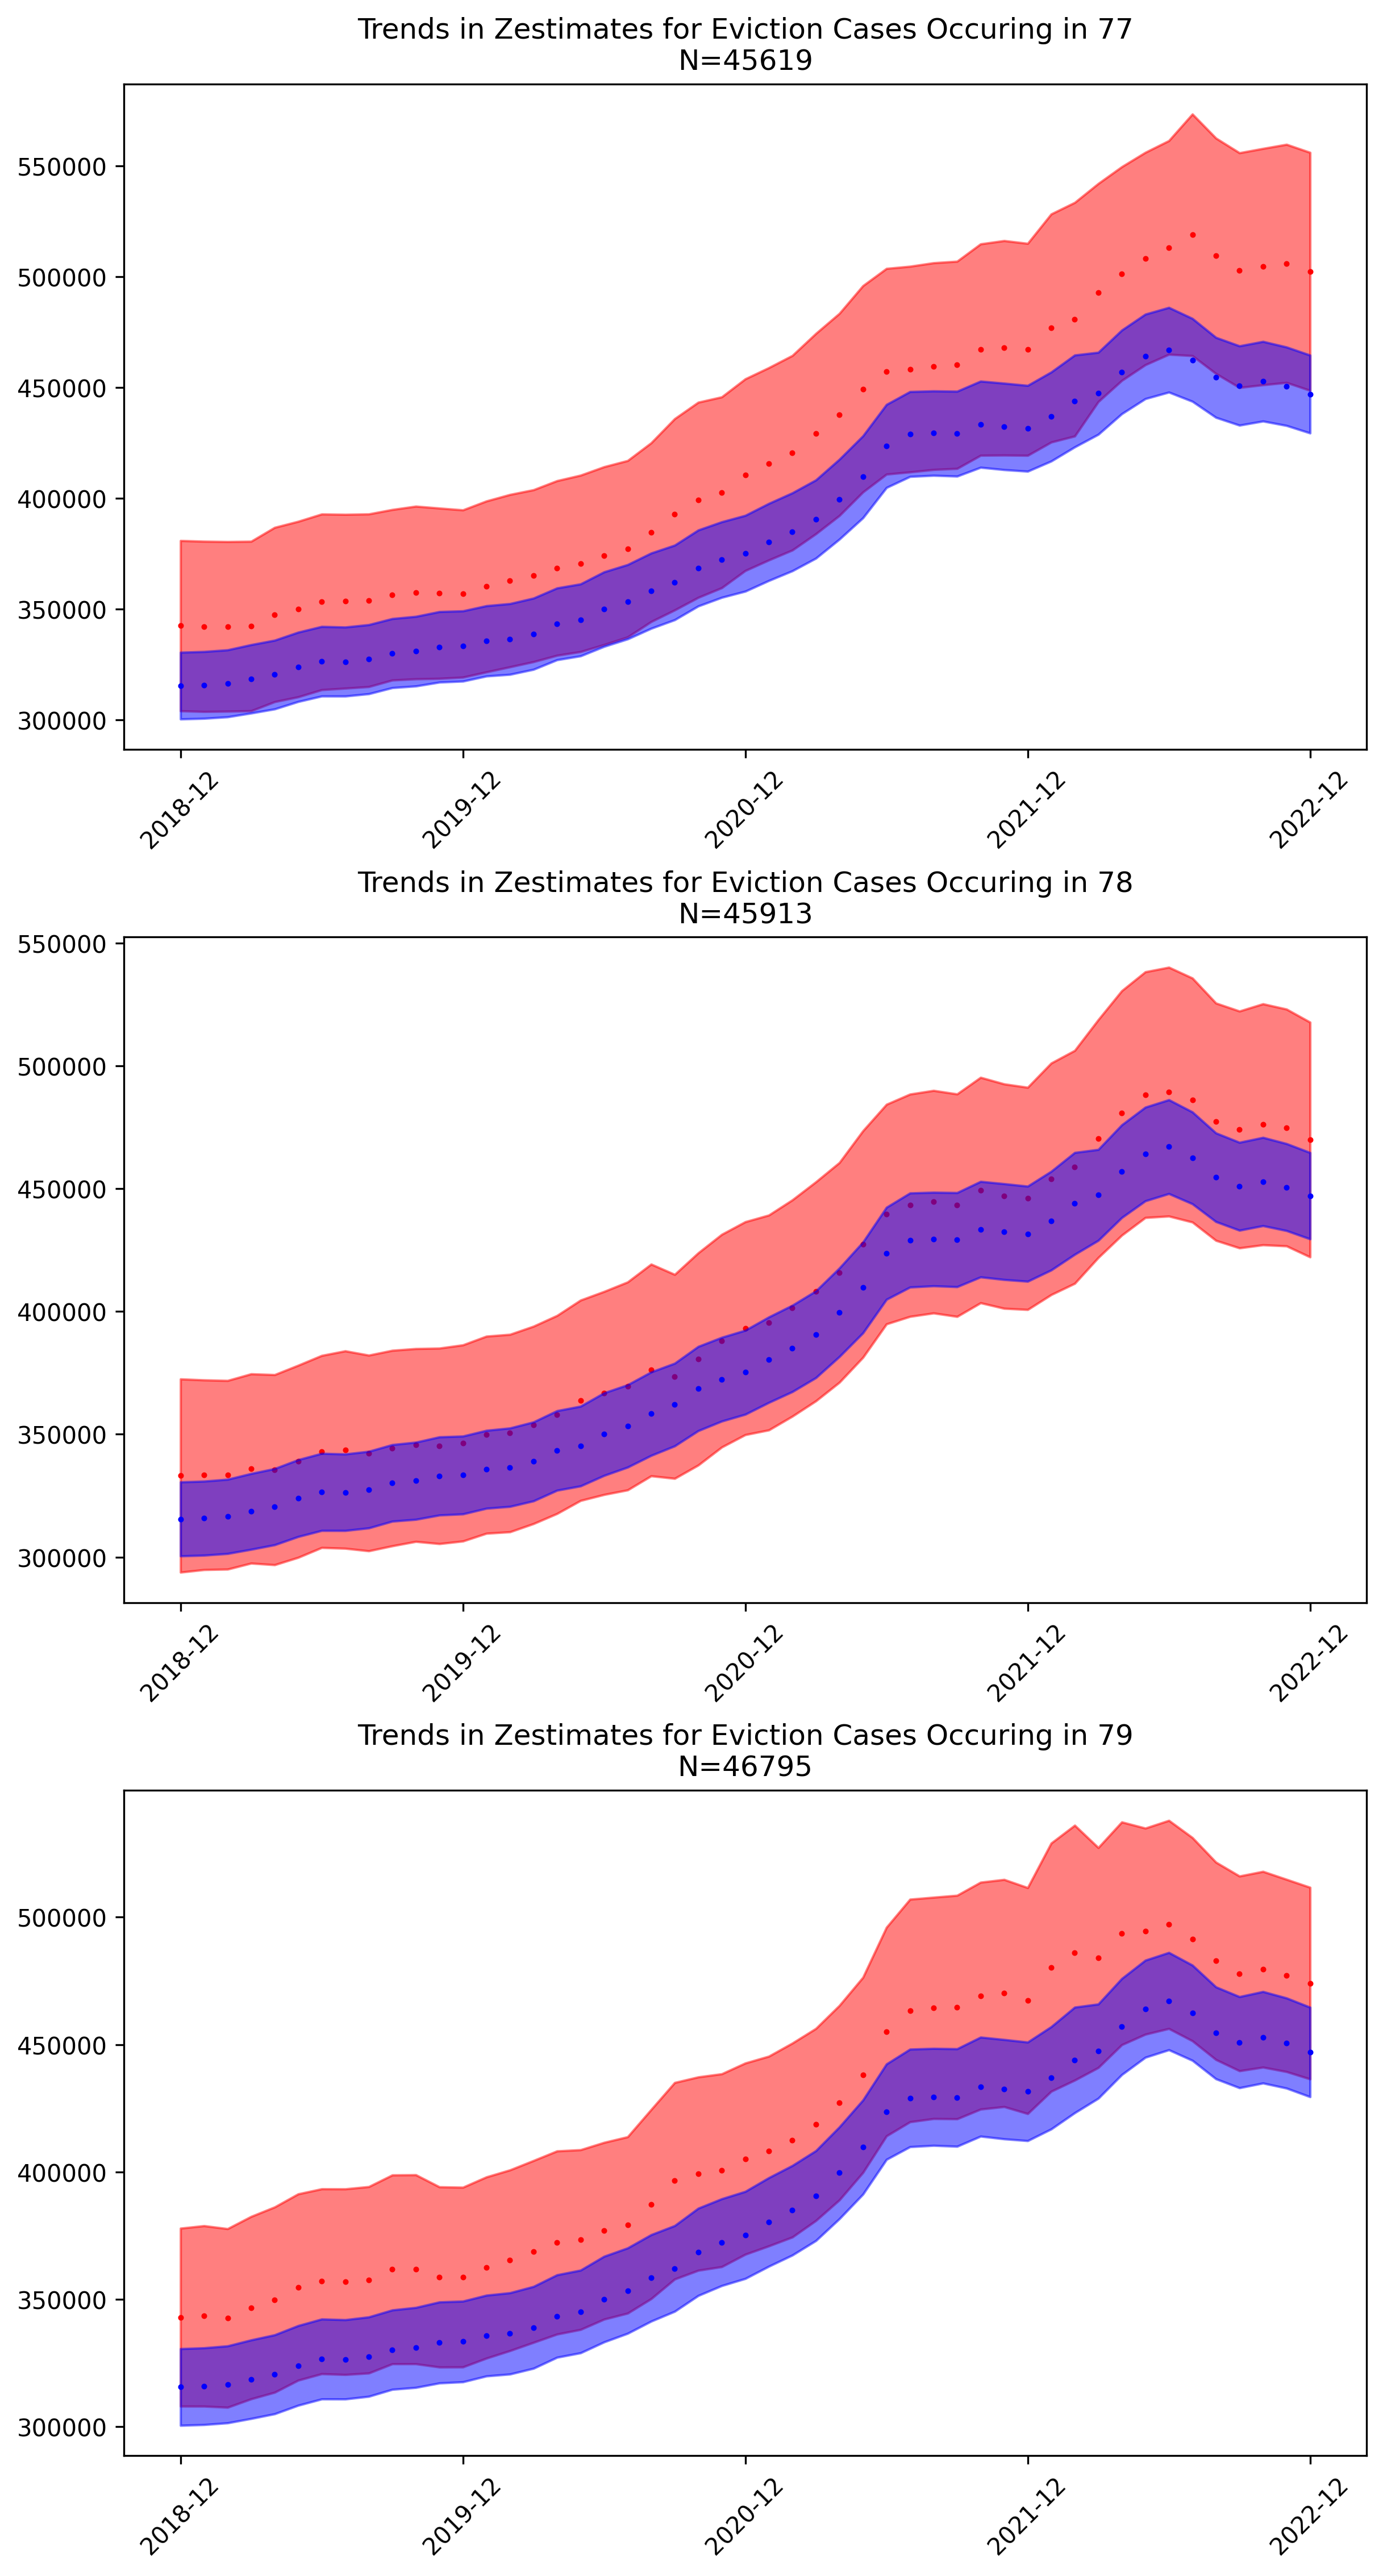

In [106]:
# Plot path of outcomes in treated group vs. control group, separately by cohort.

# Aggregate cohorts by the year of treatment.
df.loc[:, 'cohort_aggregated'] = df['file_date'].replace(int_to_month_dictionary).astype(str).str[:4]

# Plot.
fig, axes = plt.subplots(3, 1, layout='constrained', figsize=(8, 15))
aggregated_zestimates = df.groupby(['file_date', 'month'], dropna=False)['zestimate'].agg([np.mean, np.std, 'count'])
aggregated_zestimates.loc[:, 'se'] = aggregated_zestimates['std'] / np.sqrt(aggregated_zestimates['count'])
aggregated_zestimates.loc[:, 'y_upper'] = aggregated_zestimates['mean'] + 1.96*aggregated_zestimates['se']
aggregated_zestimates.loc[:, 'y_lower'] = aggregated_zestimates['mean'] - 1.96*aggregated_zestimates['se']
aggregated_zestimates = aggregated_zestimates.loc[(slice(None), slice(72, 121)), :]


for ax, aggregated_cohort in zip(axes, aggregated_zestimates.index.get_level_values('file_date').unique()):
    print(aggregated_cohort)
    sub_df_treatment = aggregated_zestimates.loc[aggregated_cohort, :]
    count_treatment = sub_df_treatment['count'].sum()
    y_treatment = sub_df_treatment['mean'].values
    x_treatment = pd.Series(sub_df_treatment.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_treatment = sub_df_treatment['y_upper'].values
    y_lower_treatment = sub_df_treatment['y_lower'].values
    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                              x_treatment,
                                              y_treatment,
                                              y_upper_treatment,
                                              y_lower_treatment,
                                                    point_color='red',
                                                    error_color='red')
    
    sub_df_control = aggregated_zestimates.loc['control', :]
    count_control = sub_df_control['count'].sum()
    y_control = sub_df_control['mean'].values
    x_control = pd.Series(sub_df_control.index.get_level_values('month')).replace(int_to_month_dictionary).values
    y_upper_control = sub_df_control['y_upper'].values
    y_lower_control = sub_df_control['y_lower'].values
    figure_utilities.plot_scatter_with_shaded_errors(ax,
                                              x_control,
                                              y_control,
                                              y_upper_control,
                                              y_lower_control,
                                                    point_color='blue',
                                                    error_color='blue')
    ax.set_xticks(range(0, len(x_treatment), 12))
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_title(f"Trends in Zestimates for Eviction Cases Occuring in {aggregated_cohort}\n"
                 f"N={count_treatment+count_control}")
plt.show()
    

In [5]:
# Run DiD.
# TODO: replace 'control' with np.NaN in level 0 of df's index
att_gt = ATTgt(data=df, cohort_name='file_date', freq='M')
result = att_gt.fit(formula='zestimate', control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 3000/3000 [01:12<00:00,


In [6]:
# Get cohort-aggregated ATT(t)s.
results_df = att_gt.aggregate('event')
results_df = results_df.loc[-10:35]
results_df.columns = results_df.columns.droplevel().droplevel()
    
# Plot event study-style plot of ATTs.
fig, ax = plt.subplots()
x = results_df.index
y = results_df['ATT']
y_upper = results_df['upper']
y_lower = results_df['lower']
ax.grid(True)
ax.set_xlabel("Month Relative to Treatment")
ax.set_ylabel("ATT")
ax.set_title("ATT(g, t) Estimates, Aggregated by Month Relative to Treatment")
figure_utilities.plot_labeled_vline(ax, x=0, text="Last Docket Date")
figure_utilities.plot_labeled_hline(ax, y=0, text="")
figure_utilities.plot_scatter_with_error_bars(ax,
                                              x,
                                              y,
                                              y_upper,
                                              y_lower)
figure_utilities.save_figure_and_close(fig, os.path.join(OUTPUT_FIGURES, "att_gt_estimates_event_study.png"))


relative_period
-10     956.882451
-9      691.267477
-8      821.126903
-7      699.340097
-6      915.530206
-5     1255.876853
-4      720.826383
-3      920.864750
-2     1043.154124
-1      853.667718
 0      774.369461
 1     1012.405485
 2     1491.970767
 3     1831.038700
 4     2082.120715
 5     2487.064289
 6     2883.096474
 7     3162.630154
 8     3355.673341
 9     3776.893884
 10    4011.339357
 11    3813.220137
 12    3955.917105
 13    4082.894967
 14    4287.827527
 15    4533.716900
 16    4594.521299
 17    4745.338549
 18    4929.311481
 19    5048.158660
 20    5289.527194
 21    5591.609325
 22    6034.194311
 23    6638.273640
 24    7239.494740
 25    7684.815247
 26    7912.910381
 27    7731.076548
 28    7895.806186
 29    7954.313977
 30    7744.953708
 31    7743.202266
 32    7479.741650
 33    7567.459644
 34    7705.760016
 35    8060.820860
dtype: float64


att_gt.plot('event')